# 3. Optimization

This exercise is devoted to: 
- convex and non-convex optimization, 
- how to use different optimizer with PyTorch, and
- how to apply some common tricks of optimization

**Imports and Utils**

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader


def plot_progress(func, track, losses, func_min, torch=False):
    """
    Adapted from 
    https://colab.research.google.com/github/davidbau/how-to-read-pytorch/blob/master/notebooks/3-Pytorch-Optimizers.ipynb
    """
    # Draw the contours of the objective function, and x, and y
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    xs = np.linspace(-2.5, 2.5, 100)
    ys = np.linspace(-1, 4, 100)
    X, Y = np.meshgrid(xs, ys)
    Z = func(np.concatenate([np.expand_dims(X, 0), np.expand_dims(Y, 0)]))
    Z = np.array(Z)

    levels = np.linspace(Z.min(), Z.max(), 100)
    manual_levels = np.array([5, 20, 100])
    levels = np.concatenate(((Z.min()+0.001) * manual_levels, levels))
    levels.sort()

    ax1.contour(X, Y, Z, levels=levels, cmap="bwr", alpha=0.5)
    track = np.stack(track).T  # (2,n)

    for i in range(len(losses)-1):
        ax1.plot(track[0, i:i+2], track[1, i:i+2], marker='o',
                 color='k', alpha=0.2 + i/(len(losses)-1) * 0.3)

    ax1.scatter(func_min[0], func_min[1], s=80, c='g', marker=(5, 1))

    ax1.set_title('progress of x')
    ax1.set_ylim(-1.0, 4)
    ax1.set_xlim(-2.5, 2.5)
    ax1.set_ylabel('x_2')
    ax1.set_xlabel('x_1')

    ax2.set_title('progress of loss')
    ax2.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))
    for i in range(len(losses)-1):
        ax2.plot([i, i+1], losses[i:i+2], marker='o',
                 color='k', alpha=0.2 + i/(len(losses)-1) * 0.3)

    ax2.hlines(func(func_min), 0, len(losses), colors='g')
    # ax2.plot(range(len(losses)), losses, marker='o', color='k')
    ax2.set_ylabel('objective')
    ax2.set_xlabel('iteration')
    fig.show()


## 3.1 With Analytical Derivatives

### 3.1.1 Case Study: Convex vs Non-Convex Optimization

For the convex optimization case, we look at the Rosenbrock function

$f_1(x) = (x_2-x_1^2)^2 + 0.01 \cdot (1-x_1)^2$

The non-convex case emerges if we add a sinosoidal signal in $x$, i.e. 

$f_2(x) = (x_2-x_1^2)^2 + 0.01 \cdot (1-x_1)^2 + 0.1 \cdot (1 + \cos(x_1))$

In [2]:
def f1(x):
    """Rosenbrock function
    Has one local and global minimum at f(1,1)=0"""
    return (x[1]-x[0] ** 2) ** 2 + 0.01 * (1-x[0]) ** 2


def grad_f1(x):
    """Gradient of Rosenbrock function"""
    dx0 = - 2 * (x[1] - x[0] ** 2) * 2 * x[0] - 2 * 0.01 * (1-x[0])
    dx1 = 2 * (x[1] - x[0] ** 2)
    return np.array([dx0, dx1])


def hess_f1(x):
    """Hessian of Rosenbrock function"""
    dxdx = 8*x[0]**2 - 4*(x[1]-x[0]**2) + 2*0.01
    dxdy = dydx = -4*x[0]
    dydy = 2
    return np.array([[dxdx, dxdy], [dydx, dydy]])


f1_min = np.array([1.0, 1.0])


def f2(x, use_torch=False):
    """Extended Rosenbrock function
    Has one global minimum f(0.63, 0.40)=0.00137 and many local minima"""
    regular_rosenbrock = (x[1]-x[0] ** 2) ** 2 + 0.01 * (1-x[0]) ** 2

    if use_torch:
        return regular_rosenbrock + 0.1 * (1 + torch.cos(5*x[0]))
    else:
        return regular_rosenbrock + 0.1 * (1 + np.cos(5*x[0]))


def grad_f2(x):
    """Gradient of extended Rosenbrock function"""
    dx0 = - 2 * (x[1] - x[0] ** 2) * 2 * x[0] - 2 * \
        0.01 * (1-x[0]) - 0.1 * np.sin(5*x[0]) * 5
    dx1 = 2 * (x[1] - x[0] ** 2)
    return np.array([dx0, dx1])


def hess_f2(x):
    """Hessian of extended Rosenbrock function"""
    dxdx = 8*x[0]**2 - 4*(x[1]-x[0]**2) + 2*0.01 - 0.1 * np.cos(5*x[0]) * 5 * 5
    dxdy = dydx = -4*x[0]
    dydy = 2
    return np.array([[dxdx, dxdy], [dydx, dydy]])


f2_min = np.array([0.63, 0.40])


In [3]:
selected_function = 2

if selected_function == 1:
    func = f1
    grad_func = grad_f1
    hess_func = hess_f1
    func_min = f1_min
else:
    func = f2
    grad_func = grad_f2
    hess_func = hess_f2
    func_min = f2_min


### 3.1.2 Gradient Descent (revised)

/tmp/ipykernel_101182/3655037485.py:53: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


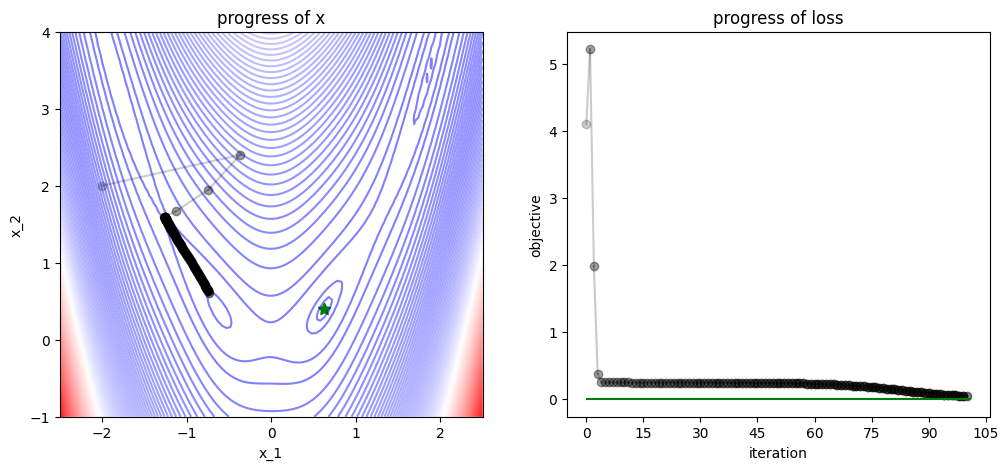

In [4]:

num_iters = 100
x = np.array([-2., 2])
track, losses = [x], [func(x)]


def gd_step(x, grad, lr=0.1):
    # GD step
    x = x - lr * grad
    return x


for iter in range(num_iters):
    # apply gradient descent
    grad = grad_func(x)
    x = gd_step(x=x, grad=grad)

    # logging
    track.append(x)
    losses.append(func(x))

plot_progress(func, track, losses, func_min)


### 3.1.3 Gradient Descent with Momentum

/tmp/ipykernel_84499/3655037485.py:53: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


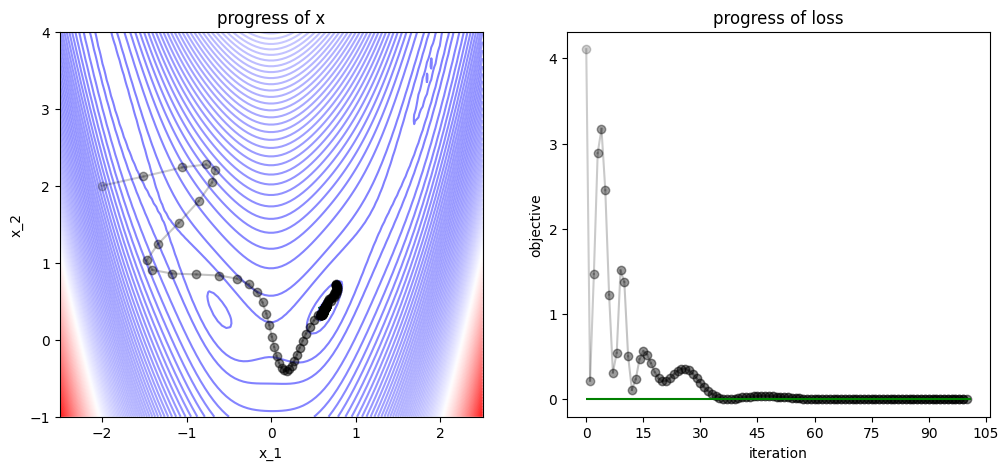

In [5]:
num_iters = 100
x = np.array([-2., 2])
v = np.zeros(x.shape)
track, losses = [x], [func(x)]


def gd_with_momentum_step(x, v, grad, lr=0.03, beta=0.9):
    # GD with momentum step
    v = beta*v + grad
    x = x - lr * v
    return (x, v)


for iter in range(num_iters):
    # apply gradient descent with momentum
    grad = grad_func(x)
    x, v = gd_with_momentum_step(x=x, v=v, grad=grad)

    # logging
    track.append(x)
    losses.append(func(x))

plot_progress(func, track, losses, func_min)


### 3.1.4 Adam

/tmp/ipykernel_84499/3655037485.py:53: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


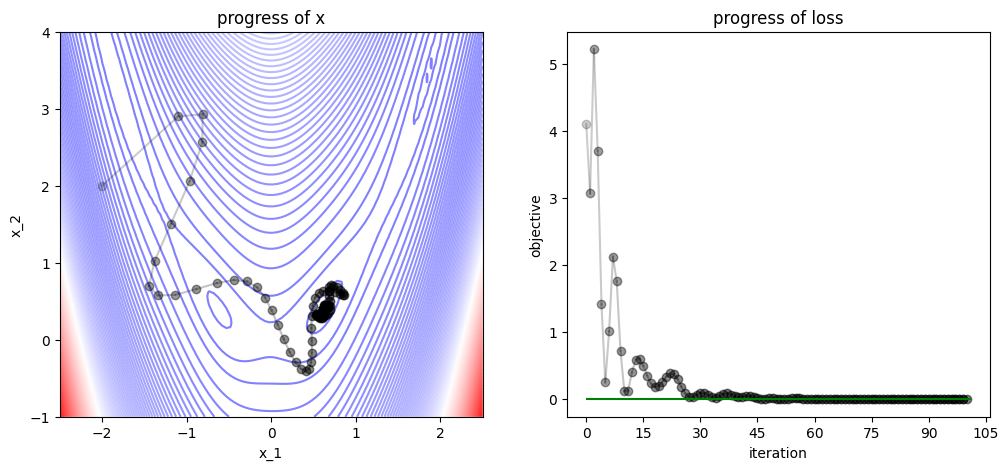

In [6]:
num_iters = 100
x = np.array([-2., 2])
v = np.zeros(x.shape)
s = np.zeros(x.shape)
track, losses = [x], [func(x)]


def adam_step(x, v, s, grad, t, lr=.9, beta1=0.9, beta2=0.999):
    # Adam step
    v = beta1 * v + (1 - beta1) * grad
    s = beta2 * s + (1 - beta2) * grad ** 2
    v_hat = v / (1 - beta1 ** t)
    s_hat = s / (1 - beta2 ** t)
    # the small number in the next line is added to avoid divisions by zero
    x = x - lr * v_hat / (np.sqrt(s_hat) + 0.0000001)
    return (x, v, s)


for iter in range(num_iters):
    # apply Adam
    grad = grad_func(x)
    x, v, s = adam_step(x=x, v=v, s=s, grad=grad, t=(iter+1))

    # logging
    track.append(x)
    losses.append(func(x))

plot_progress(func, track, losses, func_min)


### 3.1.5 Newton Optimizer

/tmp/ipykernel_84499/3655037485.py:53: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


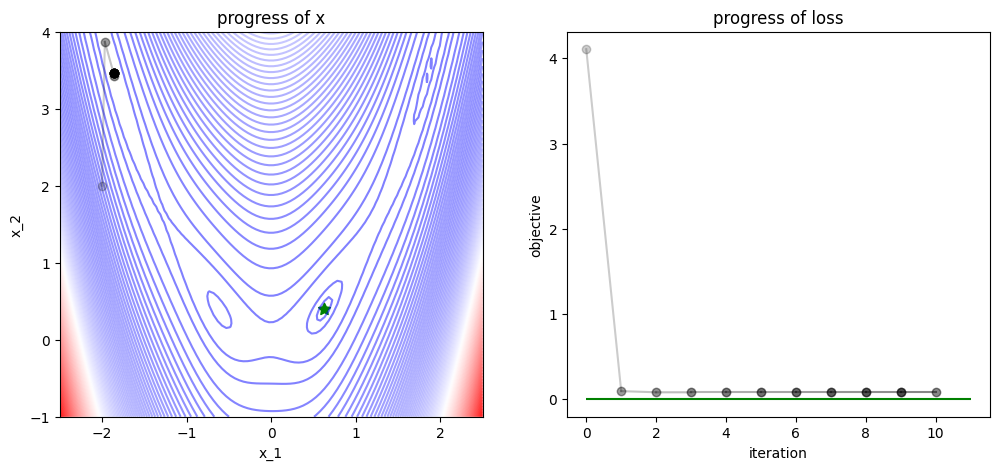

In [7]:
num_iters = 10
x = np.array([-2., 2])
track, losses = [x], [func(x)]


def newton_step(x, grad, hess, lr=1.0):
    # Newton's method step
    hess_inv = np.linalg.inv(hess)
    x = x - lr * hess_inv @ grad
    # equivalent to `x = x - lr * np.dot(hess_inv, grad)`
    return x


for iter in range(num_iters):
    # apply Newton's method
    grad = grad_func(x)
    hess = hess_func(x)

    x = newton_step(x=x, grad=grad, hess=hess)

    # logging
    track.append(x)
    losses.append(func(x))

plot_progress(func, track, losses, func_min)


### 3.1.6 Derivative-Free Optimization

Here, we compare two very similar algorithms: Grid Search and Random Search.

We assume that we know the range of the parameters, in which the minimum is contained. We then just explore the region either in a structered way (grid search) or by random sampling (random search).

Our best guess is x=[2.], y=[3.], and loss = [1.02609285]


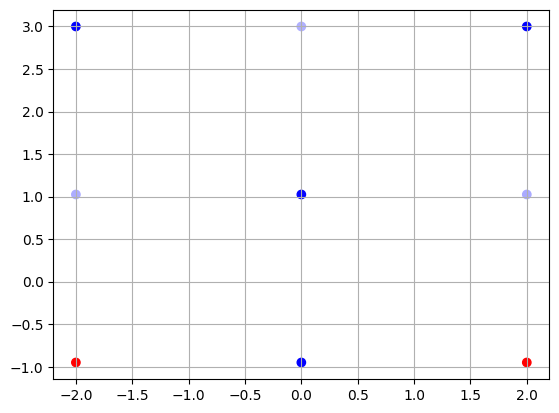

In [8]:
samples_per_dim = 3

# grid search

xs = np.linspace(-2.0, 2.0, samples_per_dim)
ys = np.linspace(-0.95, 3.0, samples_per_dim)
X, Y = np.meshgrid(xs, ys)
Z = np.zeros(X.shape)
for i in range(len(xs)):
    for j in range(len(xs)):
        Z[i, j] = func(np.array([X[i, j], Y[i, j]]))

plt.scatter(X.flatten(), Y.flatten(), c=Z.flatten(), cmap='bwr')
plt.grid()

idx = Z == Z.min()
print(
    f"Our best guess is x={X[idx]}, y={Y[idx]}, and loss = {func(np.array([X[idx], Y[idx]]))}")


Our best guess is x=[0.78587674], y=[0.5988642], and loss = [0.03026833]


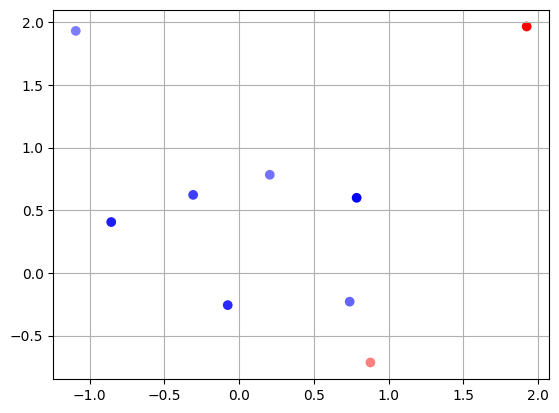

In [9]:
# random search

np.random.seed(123)
# sample randomly samples_per_dim**2 points on the x and y axis
X = np.random.uniform(-2.0, 2.0, int(samples_per_dim**2))
Y = np.random.uniform(-0.95, 3.0, int(samples_per_dim**2))
# evaluate loss at each of these points
Z = np.zeros(X.shape)
for i in range(len(Z)):
    Z[i] = func(np.array([X[i], Y[i]]))

plt.scatter(X, Y, c=Z, cmap='bwr')
plt.grid()

idx = Z == Z.min()
print(
    f"Our best guess is x={X[idx]}, y={Y[idx]}, and loss = {func(np.array([X[idx], Y[idx]]))}")


## 3.2 With PyTorch

### 3.2.1 Gradient Descent

/home/artur/Dropbox/ARTUR_Archiv/PhD/Lehre/SciML22-23/jupyter_book/SciML22-23/venv/lib/python3.9/site-packages/torch/autograd/__init__.py:197: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
/tmp/ipykernel_84499/3655037485.py:53: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


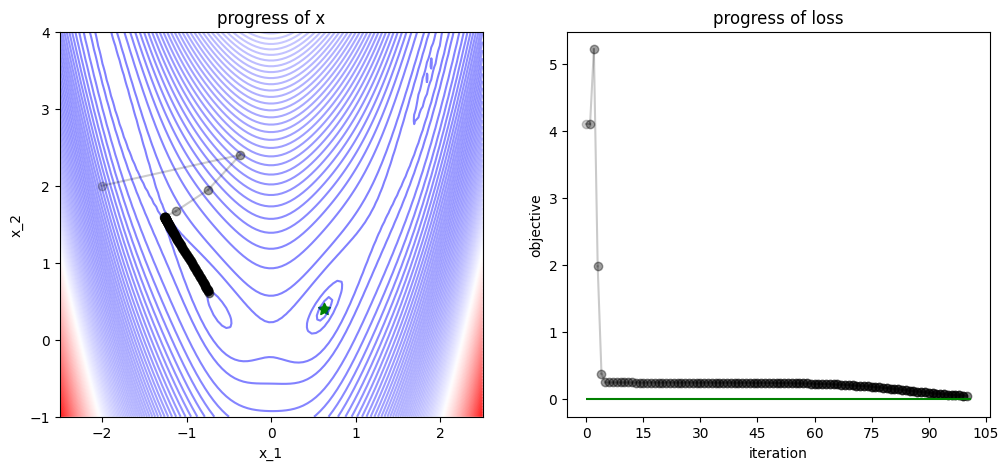

In [10]:
num_iters = 100
x_init = torch.tensor([-2.0, 2.0])
x = x_init.clone()
x.requires_grad = True
optimizer = torch.optim.SGD([x], lr=0.1)

track = [x.detach().clone().numpy()]
losses = [func(x, use_torch=True).detach().numpy()]

for iter in range(num_iters):
    loss = func(x, use_torch=True)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    track.append(x.detach().clone().numpy())
    losses.append(loss.detach().numpy())

plot_progress(func, track, losses, func_min)


### 3.2.2 Adam

/tmp/ipykernel_84499/3655037485.py:53: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


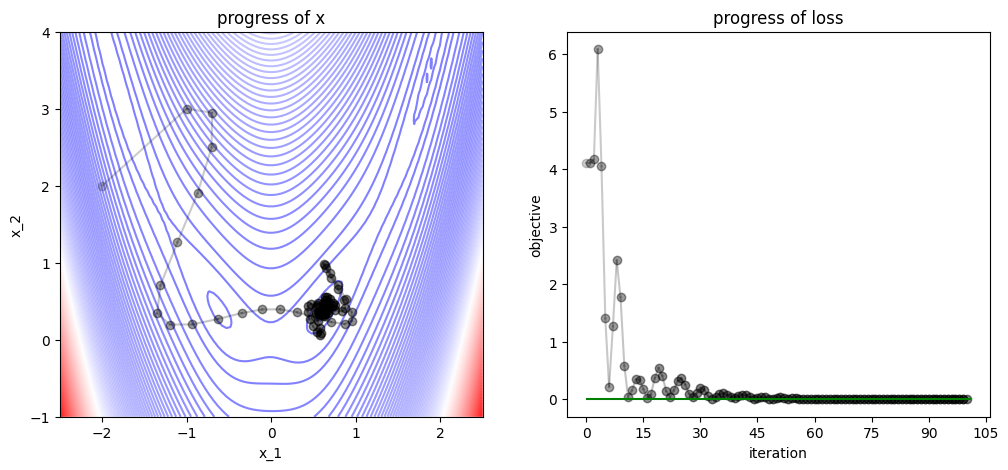

In [11]:
num_iters = 100
x_init = torch.tensor([-2.0, 2.0])
x = x_init.clone()
x.requires_grad = True
optimizer = torch.optim.Adam([x], lr=1.0, betas=(0.9, 0.95))

track = [x.detach().clone().numpy()]
losses = [func(x, use_torch=True).detach().numpy()]

for iter in range(num_iters):
    loss = func(x, use_torch=True)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    track.append(x.detach().clone().numpy())
    losses.append(loss.detach().numpy())

plot_progress(func, track, losses, func_min)


### 3.2.3 L-BFGS

/tmp/ipykernel_84499/3655037485.py:53: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


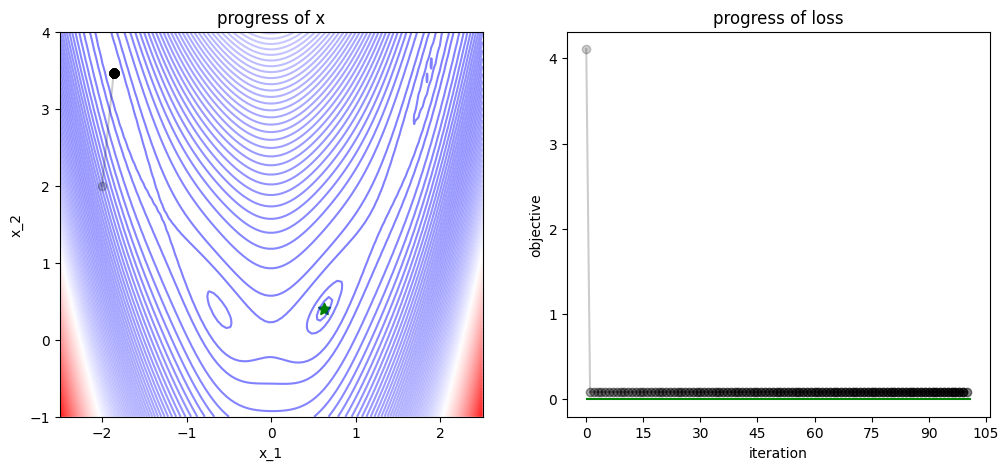

In [12]:
num_iters = 100
x_init = torch.tensor([-2.0, 2.0])
x = x_init.clone()
x.requires_grad = True
optimizer = torch.optim.LBFGS([x], lr=1.0)

track = [x.detach().clone().numpy()]
losses = [func(x, use_torch=True).detach().numpy()]

for iter in range(num_iters):
    # LBFGS requres a `closure` for the approximation of the hessian
    # typically it is the gradient:
    def closure():
        """
        from the [documentation](https://pytorch.org/docs/stable/generated/torch.optim.LBFGS.html): 
        "A closure that reevaluates the model and returns the loss."

        More information on the closure here:
        https://pytorch.org/docs/stable/optim.html
        """
        optimizer.zero_grad()
        loss = func(x, use_torch=True)
        loss.backward()
        return loss

    optimizer.step(closure)

    track.append(x.detach().clone().numpy())
    losses.append(func(x, use_torch=True).detach().numpy())

    optimizer.step(closure)


plot_progress(func, track, losses, func_min)


## 3.3 Tricks of Optimization

In [2]:
# plot util

def plot_progress_polynoial(losses, model, x_data, y_data):
    # visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # left plot
    x_linspace = torch.linspace(-1.5, 1.5, 31).unsqueeze(1)

    with torch.no_grad():
        y_pred_np = model(x_linspace).data.squeeze().numpy()

    # for plotting we transfer everything from torch to numpy
    x_data_np = x_data.detach().squeeze().numpy()
    y_data_np = y_data.detach().squeeze().numpy()
    x_np = x_linspace.squeeze().numpy()

    # plot performance
    ax1.plot(x_data_np, y_data_np, 'go', label='True data')
    ax1.plot(x_np, y_pred_np, '--', label='Predictions')
    ax1.set_ylim([-3, 3])
    ax1.legend()
    ax1.grid()

    # right plot
    ax2.plot(losses)
    ax2.set_xlabel('iteration')
    ax2.set_ylabel('loss')
    ax2.grid()

    plt.show()


# train util

def train(num_iters, model, optimizer, criterion, x_data, y_data, losses):
    print("## Parameters before training")
    for name, param in model.named_parameters():
        print(name, ": ", param.data)

    for iter in range(num_iters):

        def closure():
            optimizer.zero_grad()
            y_pred = model(x_data)
            loss = criterion(y_pred, y_data)
            loss.backward()
            return loss

        optimizer.step(closure)
        losses.append(closure().detach().item())

    # Caution: LBFGS converges very fast, but will not always converge to the 
    # true minimum. Check the left plot below to verify validity.
    print("## Parameters after training:")
    for name, param in model.named_parameters():
        print(name, ": ", param.data)

    print(f"## Loss at the end of training = {losses[-1]}")


### 3.3.1 Case Study: Polynomial Linear Regression

> Note: we move back to the typical ML notation with measurement pairs $\left\{x^{(i)}, y^{\text {(i)}}\right\}_{i=1,...m}$, model $h(x)$ which should approximate $y$, and loss $\mathcal{L}$

In this specific case we look at polynomial linear regression, i.e.

$$
h(x) = \vartheta_0 + \vartheta_1 \cdot x^1 + ... + \vartheta_p \cdot x^p
$$

We work with a very simple artificial dataset consisting on 5 measurement pairs given below. 

In [3]:
x_data = torch.tensor([[1.0, 1.5, 1.8, 2.3, 2.5]], requires_grad=True).T
y_data = torch.tensor([[3.0, 2., 2.3, 4., 1.]], requires_grad=True).T

class DummyData(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]


dummy_data = DummyData(x_data, y_data)


#### 3.3.1.1 Input Normalization

Trick Nr. 1: Input/Output normalization to zero-centered and std=1 variables.

In [4]:
# TODO: vital for an efficient training process

x_mean = x_data.mean()
x_std = x_data.std()
x_data = (x_data-x_mean)/x_std

y_mean = y_data.mean()
y_std = y_data.std()
y_data = (y_data-y_mean)/y_std

# to torch tensors with gradients
x_data = x_data.clone().detach().requires_grad_(True)
y_data = y_data.clone().detach().requires_grad_(True)


### 3.3.2 Choice of Model Complexity

Let's first construct a linear model and set up an optimization with Adam.

In [5]:
# model

class PolynomialModel(nn.Module):
    """ from https://soham.dev/posts/polynomial-regression-pytorch"""

    def __init__(self, degree):
        super().__init__()
        self._degree = degree
        # 1 is the dimension of the output y
        self.linear = nn.Linear(self._degree, 1)

    def forward(self, x):
        return self.linear(self._polynomial_features(x))

    def _polynomial_features(self, x):
        return torch.cat([x ** i for i in range(1, self._degree + 1)], 1)


**Exercise**

Try various values for the degree of the polynomial. When does overfitting begin? 

> Keep in mind: polynomial with degree `d` is able to perfectly fit `d+1` points


## Parameters before training
linear.weight :  tensor([[-0.1626, -0.4394, -0.2269]])
linear.bias :  tensor([-0.0979])
## Parameters after training:
linear.weight :  tensor([[ 2.7232, -1.1227, -2.3079]])
linear.bias :  tensor([0.5678])
## Loss at the end of training = 0.17758174240589142


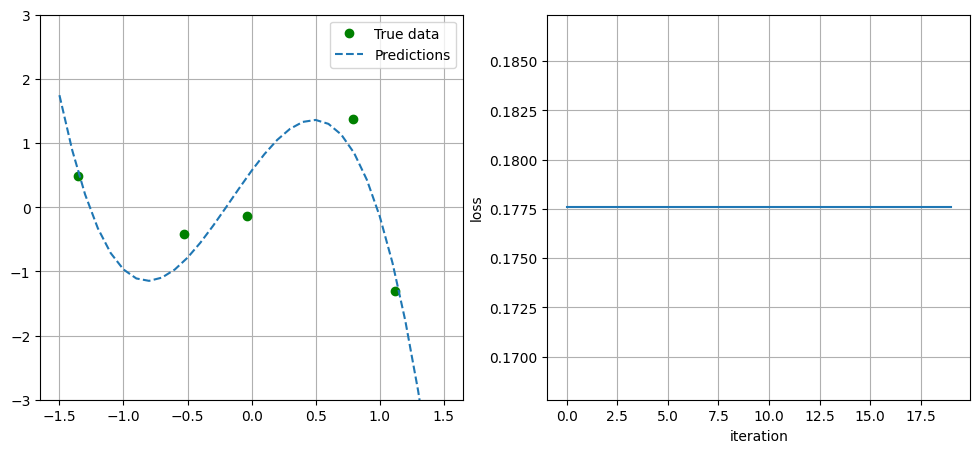

In [13]:
# TODO: try our different polynomial degrees

polynomial_degree = 3
model = PolynomialModel(polynomial_degree)
# Use LBFGS for fast convergence, but check validity of solution. 
# Remember: LBFGS is only an approximate 2nd order optimizer
optimizer = torch.optim.LBFGS(model.parameters()) 
# optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
criterion = nn.MSELoss()

losses = []
num_iters = 20

train(num_iters, model, optimizer, criterion, x_data, y_data, losses)

plot_progress_polynoial(losses, model, x_data, y_data)


### 3.3.3 Learning Rate Optimization

**Exercise**

Work with polynomial degree = 3.

Apply grid and/or random search over the learning rate of Adam. Do also combined optimization over the second order momentum parameter $\beta_2$ and learning rate.

(0.0, 5.0)

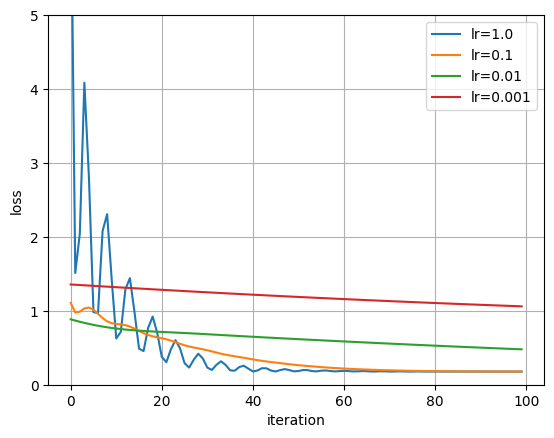

In [124]:
# TODO:

# grid search over learning rate for 1k steps

polynomial_degree = 3
num_iters = 100

lrs = [1.0, 0.1, 0.01, 0.001]

fig = plt.figure()

for lr in lrs:
    
    model = PolynomialModel(polynomial_degree)
    # Use LBFGS for fast convergence, but check validity of solution.
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    losses = []

    for iter in range(num_iters):

        def closure():
            optimizer.zero_grad()
            y_pred = model(x_data)
            loss = criterion(y_pred, y_data)
            loss.backward()
            return loss

        optimizer.step(closure)
        losses.append(closure().detach().item())

    plt.plot(losses, label=f"lr={lr}")
    

plt.xlabel("iteration")
plt.ylabel("loss")
plt.legend()
plt.grid()
plt.ylim((0, 5))

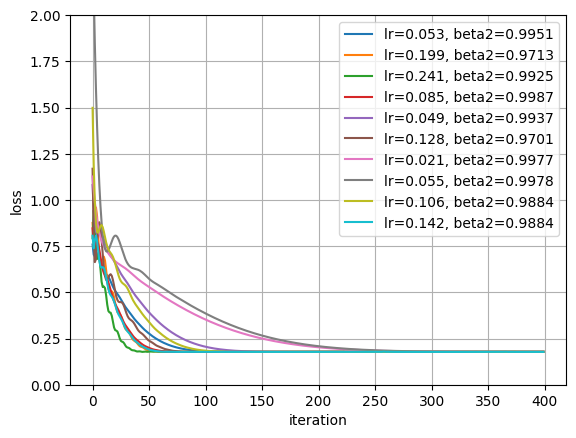

Our best guess is lr=[0.08477446 0.04933959], beta2=[0.9986837 0.993747 ], and loss = [0.17758176 0.17758176]


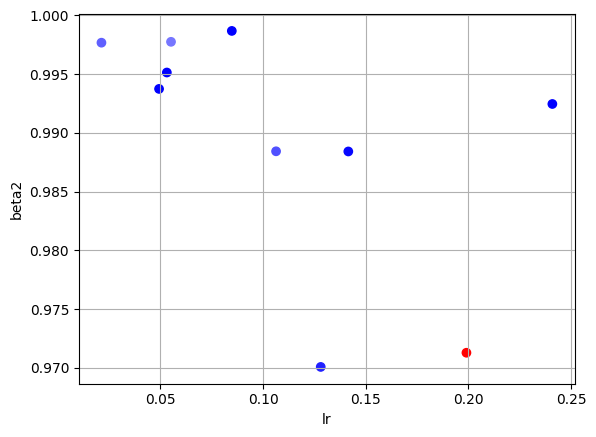

In [133]:
# random search over learning rate and beta_2 for 1k steps

def sample_loguniform(lb, ub, n):
    """Sapmle from the log-uniform distribution.
    This is very useful for explore different orders of magnitude.
    See e.g. this article: https://towardsdatascience.com/why-is-the-log-uniform-distribution-useful-for-hyperparameter-tuning-63c8d331698
    
    lb: lower boundary
    ub: upper boundary
    n: number of samples
    """
    return np.exp(np.random.uniform(np.log(lb), np.log(ub), n,))


polynomial_degree = 3
num_iters = 400

np.random.seed(123)
torch.manual_seed(123)
# log-uniform samples on the interval (0.5-0.02)
lrs = sample_loguniform(0.5, 0.02, 10)
# log-uniform samples on the interval (0.9, 0.999) finer resolved towards 1
beta2s = 1 - sample_loguniform(0.001, 0.1, 10)

# now train the model at each of these points

fig = plt.figure()

final_losses = []
for (lr, beta2) in zip(lrs, beta2s):

    model = PolynomialModel(polynomial_degree)
    # Use LBFGS for fast convergence, but check validity of solution.
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.9, beta2))
    criterion = nn.MSELoss()

    losses = []

    for iter in range(num_iters):

        def closure():
            optimizer.zero_grad()
            y_pred = model(x_data)
            loss = criterion(y_pred, y_data)
            loss.backward()
            return loss

        optimizer.step(closure)
        losses.append(closure().detach().item())
    
    final_losses.append(losses[-1])

    plt.plot(losses, label=f"lr={lr:0.3f}, beta2={beta2:.4f}")


plt.xlabel("iteration")
plt.ylabel("loss")
plt.legend()
plt.ylim((0, 2))
plt.grid()
plt.show()

# second scatter plot
fig2 = plt.figure()
final_losses = np.array(final_losses)
plt.scatter(lrs, beta2s, c=final_losses, cmap='bwr')
plt.xlabel("lr")
plt.ylabel("beta2")
plt.grid()

idx = final_losses == final_losses.min()
print(f"Our best guess is lr={lrs[idx]}, beta2={beta2s[idx]}, and loss = {final_losses[idx]}")


### 3.3.4 Learning Rate Scheduling

**Exercise**

Work with polynomial degree = 3.

Apply stepwise decreasing learning rate - in PyTorch [`MultiStepLR`](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.MultiStepLR.html#torch.optim.lr_scheduler.MultiStepLR) using the Adam optimizer.



In [31]:
from torch.optim.lr_scheduler import MultiStepLR

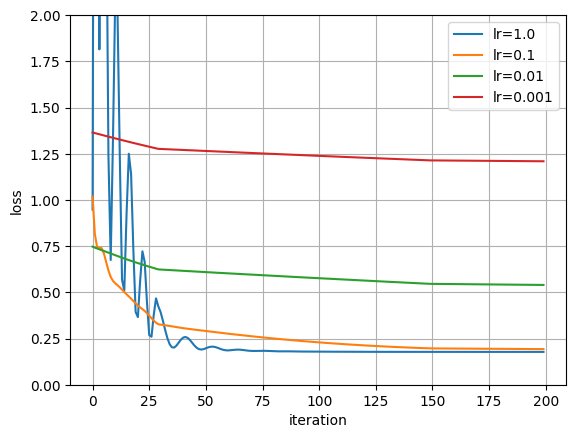

In [135]:
# TODO:

# MultiStepLR implements a learning rate which descreeses by a factor of 
# `gamma` at each of the given `milestones`, i.e. steps during optimization.

polynomial_degree = 3
num_iters = 200

lr_inits = [1.0, 0.1, 0.01, 0.001]

fig = plt.figure()

for lr in lr_inits:

    model = PolynomialModel(polynomial_degree)
    # This learning rate `lr` given to the optimizer is the initial one
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = MultiStepLR(optimizer, milestones=[30, 150], gamma=0.2)

    criterion = nn.MSELoss()

    losses = []

    for iter in range(num_iters):

        def closure():
            optimizer.zero_grad()
            y_pred = model(x_data)
            loss = criterion(y_pred, y_data)
            loss.backward()
            return loss

        optimizer.step()
        scheduler.step()
        losses.append(closure().detach().item())

    plt.plot(losses, label=f"lr={lr}")


plt.xlabel("iteration")
plt.ylabel("loss")
plt.legend()
plt.grid()
plt.ylim((0, 2))
plt.show()

# In this plot it is not apparent why LR Scheduler are so necessary, but you
# will see the true benefit when we start working with deep learning models.

### 3.3.5 Regularization

**Exercise**

Work with polynomial degree = 5.

Apply L1 and L2 regularization to the weights of the model using the Adam optimizer. 
> Hint: See [this](https://stackoverflow.com/a/66543549) discussion. More precisely, `l1_norm = sum(torch.linalg.norm(p, 1) for p in model.parameters())` and `l2_norm = sum(torch.linalg.norm(p, 2) for p in model.parameters())`

## Parameters before training
linear.weight :  tensor([[-0.1824,  0.0148, -0.2221,  0.1687, -0.3811]])
linear.bias :  tensor([0.3278])
## Parameters after training:
linear.weight :  tensor([[ 1.7465,  2.4301, -0.3584, -2.2982, -1.1679]])
linear.bias :  tensor([-0.0876])


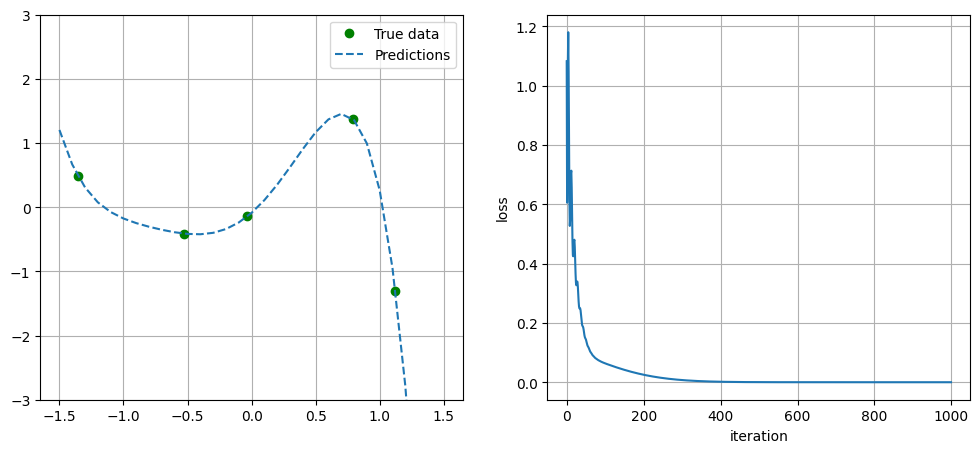

## Parameters before training
linear.weight :  tensor([[-0.3251, -0.3556, -0.2826,  0.2025, -0.1652]])
linear.bias :  tensor([0.1674])
## Parameters after training:
linear.weight :  tensor([[ 1.4652,  1.0998,  0.5008, -1.4674, -1.4747]])
linear.bias :  tensor([0.0229])


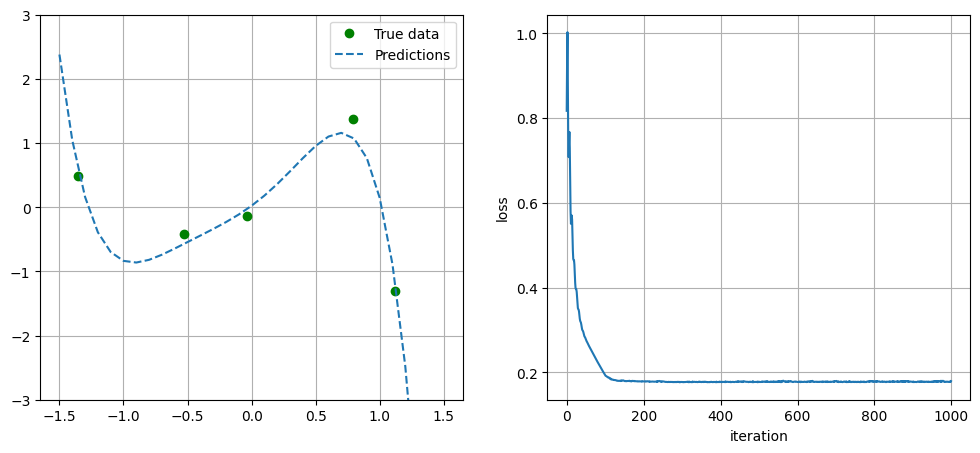

## Parameters before training
linear.weight :  tensor([[-0.3796, -0.2713, -0.1642, -0.0879, -0.3412]])
linear.bias :  tensor([0.2928])
## Parameters after training:
linear.weight :  tensor([[ 1.3994,  0.7832,  0.0303, -1.1693, -1.0776]])
linear.bias :  tensor([0.0577])


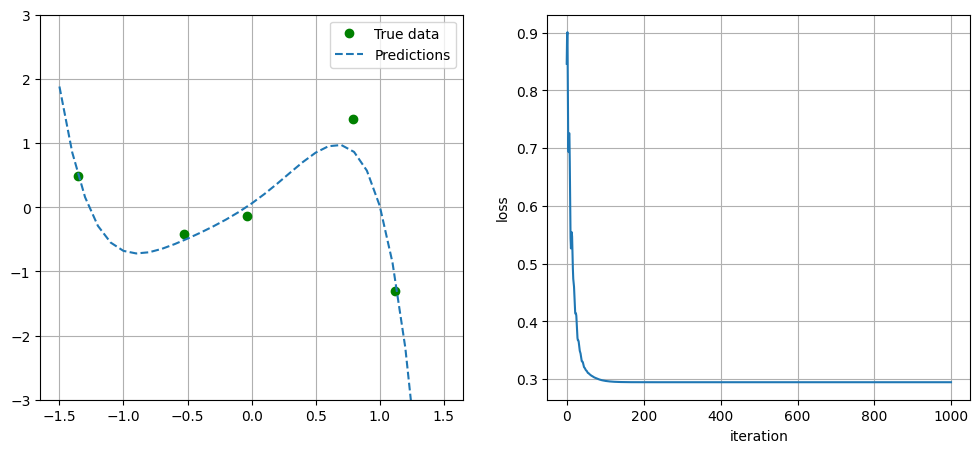

In [15]:
# TODO: 

polynomial_degree = 5
num_iters = 1000
# weighting value for regularization term in the loss
reg_lambda = 0.1

def no_reg(model):
    """no regularization"""
    return 0

def l1_reg(model):
    """l1 regularization"""
    return sum(torch.linalg.norm(p, 1) for p in model.parameters())

def l2_reg(model):
    """l2 regularization
    Using `torch.optim.Adam`, this regularization is already there under the 
    parameter `weight_decay`
    """
    return sum(torch.linalg.norm(p, 2) for p in model.parameters())


np.random.seed(123)
torch.manual_seed(123)

for reg in [no_reg, l1_reg, l2_reg]:
    losses = []
    
    model = PolynomialModel(polynomial_degree)
    # optimizer = torch.optim.LBFGS(model.parameters())
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
    criterion = nn.MSELoss()

    print("## Parameters before training")
    for name, param in model.named_parameters():
        print(name, ": ", param.data)
        
    for iter in range(num_iters):

        def closure():
            optimizer.zero_grad()
            y_pred = model(x_data)
            # here we apply regularization
            loss = criterion(y_pred, y_data) + reg_lambda * reg(model)
            loss.backward()
            return loss

        optimizer.step(closure)
        losses.append(closure().detach().item())

    print("## Parameters after training:")
    for name, param in model.named_parameters():
        print(name, ": ", param.data)

    plot_progress_polynoial(losses, model, x_data, y_data)
